In [1]:
import string

import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns

import nltk
nltk.download("stopwords")
nltk.download('wordnet')
nltk.download('vader_lexicon')

from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import FreqDist
from nltk.sentiment import SentimentIntensityAnalyzer

from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shrutirao/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/shrutirao/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/shrutirao/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
df = pd.read_csv('data/cleaned_data.csv', index_col=0)

In [3]:
df.describe()

,floor,ground-floor,1-floor,2-floor,3-floor,emotion,comfort,occupation,usage,recruitment
count,142,34,72,13,13,126,122,125,128,125
unique,5,6,6,3,4,113,112,2,2,2
top,1st Floor,Round tables by the three plants (across woode...,Green group study tables (between a row of pla...,Library learning room,Open lounge area,Calm,Very comfortable,Yes,Yes,I will be only be participating in the survey
freq,74,11,24,9,5,5,6,114,106,99


# Overview of Respondents

In [4]:
df.occupation.value_counts()

Yes    114
No      11
Name: occupation, dtype: int64

In [5]:
df.recruitment.value_counts()

I will be only be participating in the survey     99
I would like to participate in a building walk    26
Name: recruitment, dtype: int64

# Students Across the Floors

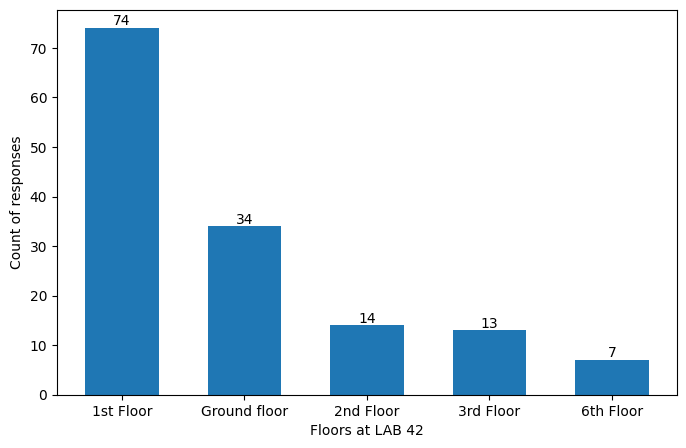

In [6]:
fig, ax = plt.subplots()
data = df.floor.value_counts()
data = pd.DataFrame(data).reset_index().rename(columns={"index": "Floor", "floor": "Count of Responses"})
width = 0.6

p=ax.bar(data.Floor, data["Count of Responses"], width)
ax.bar_label(p, label_type='edge')
plt.ylabel("Count of responses")
plt.xlabel("Floors at LAB 42")
fig.set_size_inches(8, 5)
plt.savefig('plots/floors-responses.jpg', dpi=300, bbox_inches="tight")

In [7]:
floor_df = df[['floor', 'ground-floor', '1-floor', '2-floor', '3-floor' ]]
ground_floor = floor_df[floor_df['floor'] == 'Ground floor'].iloc[:, 0:2].value_counts()
first_floor = floor_df[floor_df['floor'] == '1st Floor'].loc[:, ['floor', '1-floor']].value_counts()
second_floor = floor_df[floor_df['floor'] == '2nd Floor'].loc[:, ['floor', '2-floor']].value_counts()
third_floor = floor_df[floor_df['floor'] == '3rd Floor'].loc[:, ['floor', '3-floor']].value_counts()

In [8]:
df[df['floor'] == '6th Floor']

,floor,ground-floor,1-floor,2-floor,3-floor,emotion,comfort,occupation,usage,recruitment
4,6th Floor,NaN,NaN,NaN,NaN,"Hungry, a bit cold","Cold, quiet, well lit",NaN,Yes,I would like to participate in a building walk
18,6th Floor,NaN,NaN,NaN,NaN,NaN,NaN,No,Yes,I would like to participate in a building walk
37,6th Floor,NaN,NaN,NaN,NaN,"Tired, busy",Noisy (poor sound insulation between rooms),No,Yes,I will be only be participating in the survey
38,6th Floor,NaN,NaN,NaN,NaN,Peaceful,Default brightness is a little bright,Yes,Yes,I would like to participate in a building walk
41,6th Floor,NaN,NaN,NaN,NaN,Ok,Ok,Yes,Yes,I will be only be participating in the survey
75,6th Floor,NaN,NaN,NaN,NaN,"Convenient, and calm sometime",I am quite comfortable with the overall enviro...,No,Yes,I will be only be participating in the survey
123,6th Floor,NaN,NaN,NaN,NaN,Calm,8/10,Yes,No,I will be only be participating in the survey


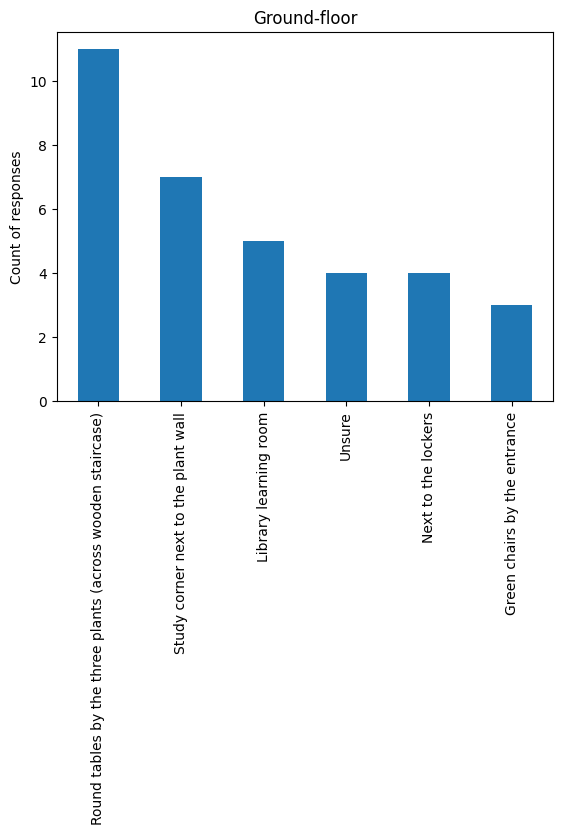

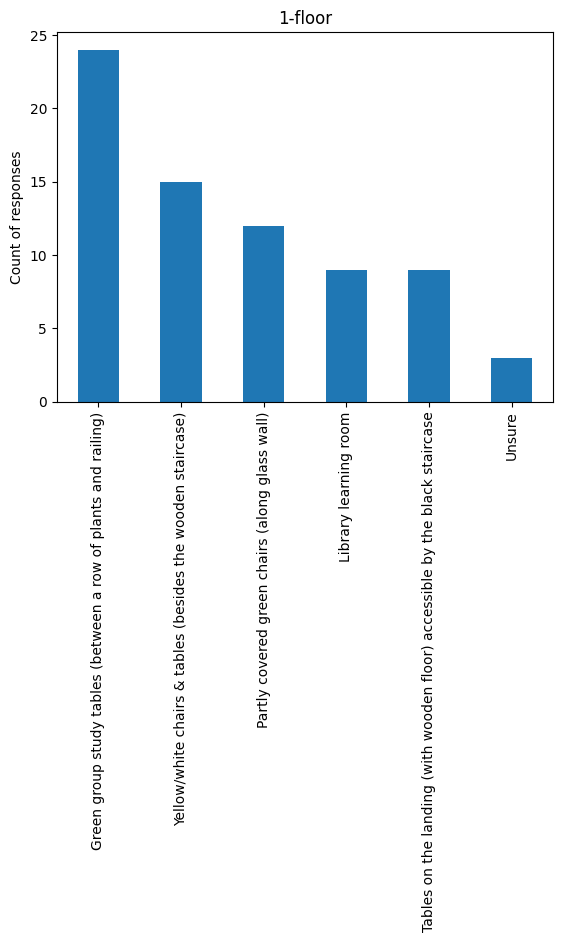

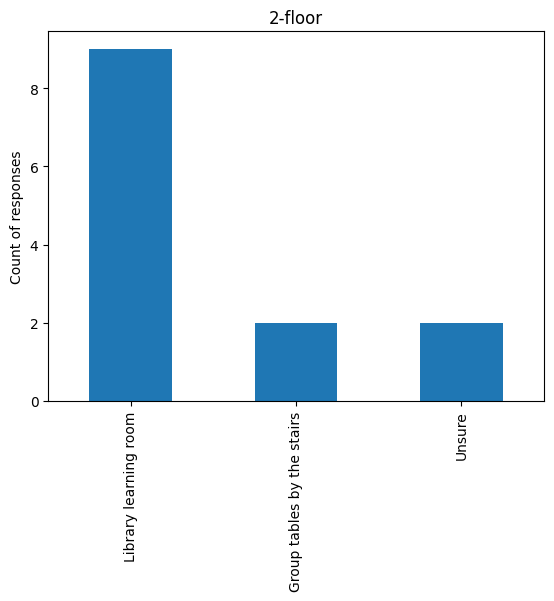

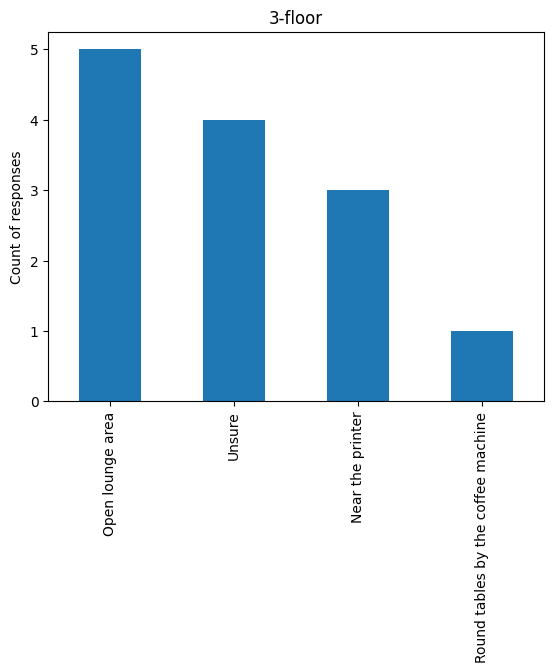

In [30]:
def plot_responses_rooms(floor):
    # ax = plt.subplot(2, 2, n + 1)
    p = df[floor].value_counts().plot.bar()
    # ax.bar_label(p, label_type='edge')
    plt.ylabel("Count of responses")
    plt.title(floor.capitalize())

# plt.figure(figsize=(15, 12))
# plt.subplots_adjust(hspace=3)
floors = ['ground-floor', '1-floor', '2-floor', '3-floor']

for floor in floors:
    fig, ax = plt.subplots()
    plot_responses_rooms(floor)
    plt.savefig('plots/' + floor + '.jpg',
            dpi=300, bbox_inches='tight')

# Emotions

In [31]:
df_emo = df.emotion.dropna()
df_emo = df_emo.apply(lambda x: x.replace('’', ''))

### Tokenise

In [32]:
df_emo

1      I always feel a bit zen when I am here. Its qu...
2                                       Cold, a bit down
3                                                   Calm
4                                     Hungry, a bit cold
5      Stressed about my exams but I am happy in this...
                             ...                        
148    Im a little cold, but otherwise calm and comfo...
149                                 Relaxed and focused 
150                                       Pretty relaxed
152                                         Comfortable 
153                                            Its good 
Name: emotion, Length: 126, dtype: object

In [33]:
import string

def apply_token(row):
    stop_words = set(stopwords.words("english"))
    words_in_sent = word_tokenize(row)

    filtered_list = []
    
    for word in words_in_sent:
        if word.casefold() not in stop_words:
            filtered_list.append(word)
    
    return filtered_list

In [34]:
df_emo = df_emo.apply(apply_token)

In [35]:
def cleanup(df_emo):
    combo_emo = []
    for row in df_emo:
        combo_emo.append(row)
    
    combo_emo = list(np.concatenate(combo_emo).flat)
    combo_emo = list(filter(lambda token: token not in string.punctuation,
                            combo_emo))
    combo_emo = [x.lower() for x in combo_emo]
    
    return combo_emo

In [36]:
combo_emo_list = cleanup(df_emo)

In [37]:
frequency_distribution = FreqDist(combo_emo_list)
frequency_distribution.most_common(20)

[('calm', 30),
 ('relaxed', 15),
 ('like', 12),
 ('happy', 10),
 ('feel', 9),
 ('good', 9),
 ('bit', 8),
 ('neutral', 8),
 ('comfortable', 8),
 ('nice', 8),
 ('tired', 7),
 ('focused', 7),
 ('feels', 6),
 ('atmosphere', 6),
 ('quiet', 5),
 ('cold', 5),
 ('motivated', 5),
 ('peaceful', 5),
 ('space', 5),
 ('study', 5)]

In [38]:
def frequency_distribution(lst, label):
    top_n = FreqDist(lst).most_common(20)
    frequency_distribution = pd.Series(dict(top_n))

    sns.set_theme(style="ticks")
    sns.barplot(y=frequency_distribution.index,
                x=frequency_distribution.values,
                palette = 'hls',
                saturation = 8)
    plt.xlabel("Count of responses")
    plt.ylabel("Most frequently occuring responses")
    plt.gcf().set_size_inches(5,7)
    # plt.xlim(0,20)

    plt.savefig('plots/' + label + '-freq-dist.jpg',
            dpi=300, bbox_inches='tight')

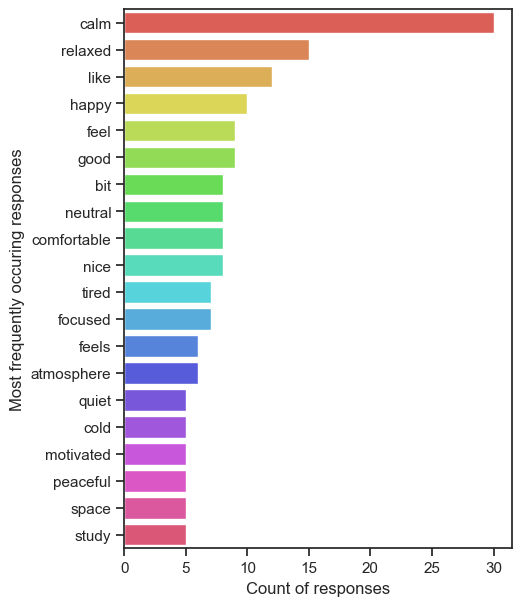

In [39]:
frequency_distribution(combo_emo_list, 'emo')

calm (19), bit (6), nice (5), feel (4), quiet (4), neutral (4), relaxed (4), focused (4), noisy (3), cold (3), stressed (3), happy (3), motivated (3), peaceful (3), tired (3), good (3), study (3), building (3)

Interesting to note that words associated with emotion questions also included some words about comfort such as `cold` and `noisy`. Overall, we see that words associated with emotions are a mix of emotions, moods, sentiments, that are also typically associated with learning (`stressed`, `focused`, `motivated`)

### Lemmatisation

In [40]:
def lemmatiser(labels):
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in labels]
    return lemmatized_words

def check_collocations(lst):
    return nltk.Text(lst).collocations()
    
def find_collocations(df_emo):
    lem_emo = df_emo.apply(lemmatiser)
    combined_emos = list(np.concatenate(lem_emo.to_list()).flat)
    return check_collocations(combined_emos)

In [41]:
find_collocations(df_emo)

feeling fine; ground floor; natural light; feel like; day studying;
Nice quiet; feel bit; feel cozy; calm comfortable; study Calm; calm
Calm


study calm were the most frequently occuring pair of words (collocations) in the list of emotions.

# Comfort

In [46]:
df_comfort = df.comfort.dropna()
df_comfort = df_comfort.apply(lambda x: x.replace('’', ''))

### Tokenise

In [47]:
df_comfort = df_comfort.apply(apply_token)
combo_comfort_list = cleanup(df_comfort)

In [48]:
combo_comfort_list = [word for word in combo_comfort_list if word != "'s"]

In [49]:
frequency_distribution = FreqDist(combo_comfort_list)
frequency_distribution.most_common(20)

[('comfortable', 52),
 ('light', 28),
 ('noise', 24),
 ('good', 23),
 ('bit', 22),
 ('temperature', 19),
 ('cold', 18),
 ('air', 17),
 ('nice', 14),
 ('quality', 13),
 ('feel', 13),
 ('like', 12),
 ('pretty', 12),
 ('little', 12),
 ('noisy', 11),
 ('quite', 10),
 ('room', 8),
 ('space', 7),
 ('lot', 7),
 ('fine', 7)]

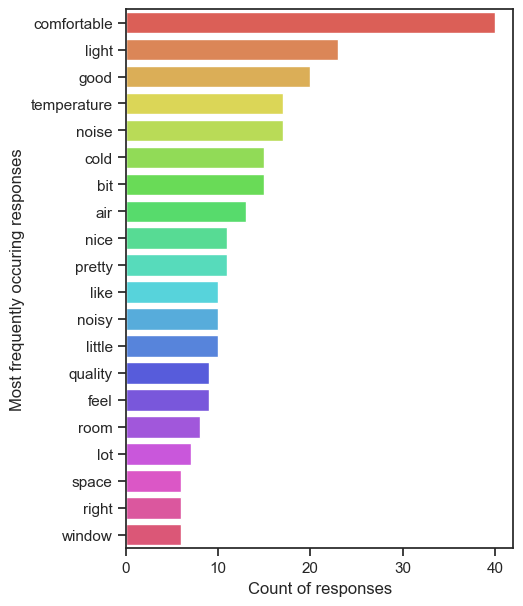

In [45]:
frequency_distribution(combo_comfort_list, 'comfort')

'comfortable' (23), 'light'(12), 'cold' (10), 'good' (10), 'noise' (9), 'temperature' (8), 'air' (8), 'nice' (8), 'room' (7), ('pretty', 7), ('space', 5), ('quality', 5), ('window', 5), ('fine', 5), ('like', 5), ('noisy', 5), ('little', 5), ('well', 4), ('lighting', 4), ('warm', 4), ('lot', 4), ('make', 4), ('feel', 4), ('blinds', 4), ('dark', 4), ('natural', 4), ('ok', 4), ('perfect', 3)

Most focus on light and temperature followed by noise. People also noted overall space and comfort as a whole. 

### Lemmatisation

In [50]:
find_collocations(df_comfort)

air quality; Pretty comfortable; natural light; bit noisy; sitting
window; lecture break; feel comfortable; much noise; quality could;
Air quality; Temperature okay; hear people; background noise; could
better; even though; many people; bit dark; bit cold; Quite
comfortable; like sitting


Air quality was the most ferquently occuring word.

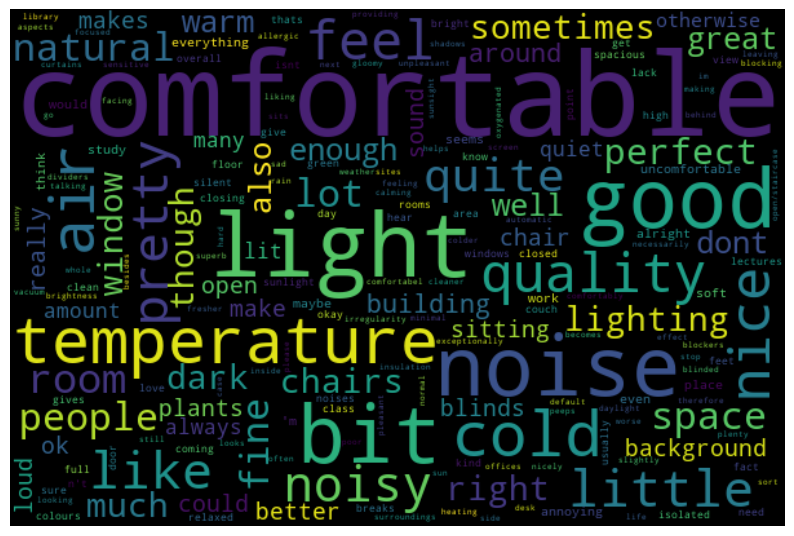

In [51]:
from collections import Counter
combo_comfort_cloud=Counter(combo_comfort_list)

wordcloud = WordCloud(width=600, 
                     height=400, 
                     random_state=2, 
                     max_font_size=100).generate_from_frequencies(combo_comfort_cloud)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off');

# Sentiment Analysis

In [42]:
def sentiment_analysis(df, label):
    analyzer = SentimentIntensityAnalyzer()
    df[label + '-polarity'] = df[label].apply(lambda x: analyzer.polarity_scores(str(x)))
    df = pd.concat([df, df[label + '-polarity'].apply(pd.Series)], axis=1)
    df[label + '-sentiment'] = df['compound'].apply(lambda x: 'positive' if x >0 else 'neutral' if x==0 else 'negative')

    print("Most positive emotion statement: ", df.loc[df['compound'].idxmax()].values)
    print("\n")
    print("Most negative emotion statement: ", df.loc[df['compound'].idxmin()].values)
    
    return df 

In [43]:
def plot_sentiment_analysis(df, label):
    sns.countplot(y=label+'-sentiment', 
                  data=df,
                  palette=['#b2d8d8',"#008080", '#db3d13'])
    plt.ylabel("Sentiment for " + label + " Text")
    plt.xlabel("Count")
    # plt.xlim(0,45)
    plt.savefig('plots/' + label + '-sentiment-count.jpg',
                dpi=300, bbox_inches='tight')
    
    plt.clf()
    
    sns.boxplot(x='floor', y='compound', data=df)
    plt.xlabel("Floor")
    plt.ylabel("Sentiment Value \n (1 = Most Positive; 0 = Neutral; -1 = Most Negative)")
    plt.tick_params(bottom=False)
    plt.axhline(0, ls='--', c = 'grey')
    plt.savefig('plots/' + label + '-sentiment-distribution.jpg',
                dpi=300, bbox_inches='tight')

In [72]:
df_sent_emo = sentiment_analysis(df, 'emotion')

Most positive emotion statement:  ['1st Floor' nan 'Partly covered green chairs (along glass wall)' nan nan
 'Calm. Motivated. '
 "I love sitting by the window to have more (natural) light. it's a bit dark otherwise and air quality could be better, but I'm allergic and therefore more sensitive. it's a bit too warm for my liking, but not necessarily unpleasant. I love the colours. Green always has a calming effect on me"
 'Yes' 'Yes' 'I will be only be participating in the survey'
 {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.6486}
 {'neg': 0.042, 'neu': 0.607, 'pos': 0.351, 'compound': 0.9654} 0.042
 0.607 0.351 0.9654 'positive']


Most negative emotion statement:  ['Ground floor' 'Study corner next to the plant wall' nan nan nan
 'Neutral'
 'My chair makes my back hurt and I the lack chalkboards gives me existential pain. 7/10'
 'Yes' 'Yes' 'I will be only be participating in the survey'
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
 {'neg': 0.429, 'neu': 0.571, 'pos':

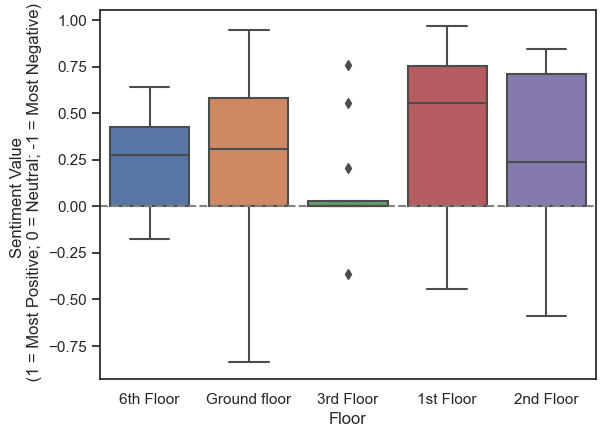

In [53]:
plot_sentiment_analysis(df_sent_emo, 'comfort')

### Emotion: `Calm`

In [70]:
df_sent_emo[['floor','emotion', 'emotion-sentiment']][df_sent_emo['emotion'].str.contains("calm")==True]

,floor,emotion,emotion-sentiment
5,Ground floor,Stressed about my exams but I am happy in this...,positive
12,Ground floor,"Stable, calm",positive
15,2nd Floor,"Relaxed, calm",positive
22,2nd Floor,"tired, calm",negative
58,1st Floor,focused calm,positive
75,6th Floor,"Convenient, and calm sometime",positive
76,1st Floor,"Really nice, I feel calm",positive
91,1st Floor,Very calm and it feels spacious,positive
101,1st Floor,I like to be isolated in a open space with nat...,positive
122,Ground floor,"Safe, open, calm, relaxed.",positive


In [68]:
df_sent_emo['emotion'][df_sent_emo['emotion'].str.contains("relaxed")==True]:
    print(row)

Calm, focused, relaxed
It's a relaxed atmosphere. I feel like wanted to do work because others are doing so near me. The acoustics of the building als makes the noise level very acceptable
Quite relaxed due to having sufficient natural light. Facing the grass walls also makes me quite happy albeit the hectic studying and hence high screen time rates.
Focussen and relaxed
Peaceful and relaxed 
It is open, and this does not necessarily make me relaxed, it feels like i am standing in a hall/pass way, not really a study area. I like that it is naar window, where you can see people walking and going somewhere. I like it is fading rhe sunny side, makes me happy
Fine, relaxed
Comforting, relaxed, concentrated 
Safe, open, calm, relaxed. 
Pretty relaxed


## Comfort: `light`

In [74]:
df_sent_comfort = sentiment_analysis(df, 'comfort')

Most positive emotion statement:  ['1st Floor' nan 'Partly covered green chairs (along glass wall)' nan nan
 'Calm. Motivated. '
 "I love sitting by the window to have more (natural) light. it's a bit dark otherwise and air quality could be better, but I'm allergic and therefore more sensitive. it's a bit too warm for my liking, but not necessarily unpleasant. I love the colours. Green always has a calming effect on me"
 'Yes' 'Yes' 'I will be only be participating in the survey'
 {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.6486}
 {'neg': 0.042, 'neu': 0.607, 'pos': 0.351, 'compound': 0.9654} 0.042
 0.607 0.351 0.9654 'positive']


Most negative emotion statement:  ['Ground floor' 'Study corner next to the plant wall' nan nan nan
 'Neutral'
 'My chair makes my back hurt and I the lack chalkboards gives me existential pain. 7/10'
 'Yes' 'Yes' 'I will be only be participating in the survey'
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
 {'neg': 0.429, 'neu': 0.571, 'pos':

In [85]:
for row in df_sent_comfort['comfort'][df_sent_comfort['comfort'].str.contains("light")==True]:
    print(row, "\n")

The light in the offices is perfect, as well as the amount of space. The temperature is comfortabel as well. 

Temperature (it’s too cold), lack of light (but that’s because of the weather), noise (sound of rain), so not feeling very comfortable  

Comfortable temperature and pleasant lighting. The air quality is also good. 

Usually it is really nice and comfortably warm in here, but right now it is a bit cold because a window was open. There is a lot of daylight which makes the room more comfortable to be in. There are not many noises which is great. 

It's cold, but the amount of sunlight and warm colours make up for that. I feel comfortable  

The temperature is always a bit cold in the very open space,there was no noise, light was fine. I just dont like that it is that open. 

Very comfortable it’s the perfect temperature minimal noise and enough lighting  

Pretty comfortable, it is quiet and light. The view isn’t great as the surroundings are still building sites. Air could be f

In [ ]:
df = sentiment_analysis(df, 'emotion')

In [ ]:
df = sentiment_analysis(df, 'comfort')

In [ ]:
plot_sentiment_analysis(df, 'comfort')